## Transfer Learning

**Name**: Akash Kharita <br>
**Email**: ak287@uw.edu <br>
**Collaborators**: Marine Denolle and Michael West <br>
**Study**: Discrimination between Ice and Earthquakes in southern Alaska: an exploration waveform features using
random forest algorithm. 

In [1]:
## importing necessary dependies

import obspy 
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from tqdm import tqdm
import os
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from obspy.geodetics.base import gps2dist_azimuth

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.feature_selection import RFE

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from obspy.clients.fdsn import Client
client = Client("IRIS")

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from functools import reduce

#from tsfresh import extract_features
#from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters
import time
import pygmt
import matplotlib
import random

### setting some plot parameters

In [2]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 5
#mpl.rcParams['font.weight'] = 'bold'


cmap = matplotlib.cm.get_cmap('magma')
c1 = cmap(0.1)
c2 = cmap(0.3)
c3 = cmap(0.5)
c4 = cmap(0.7)
c5 = cmap(0.9)
c6 = cmap(1.0)

/tmp/ipykernel_1487308/3682869775.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma')


## downloading the catalog information

In [3]:
iq_lats = pd.read_csv('../Catalogs/icequakes_catalog.csv')['latitude']
iq_lons = pd.read_csv('../Catalogs/icequakes_catalog.csv')['longitude']

eq_lats = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['latitude']
eq_lons = pd.read_csv('../Catalogs/earthquakes_catalog.csv')['longitude']

stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])


stations = stns.values[:,1].astype('str')
stn_lats = stns.values[:,2].astype('float')
stn_lons = stns.values[:,3].astype('float')
gl_lat, gl_lon = 61.219722, -146.895278

## Defining the order from least to most number of events at each station

In [4]:
no_of_icequakes = []
no_of_earthquakes = []
for i in range(15):
    no_of_icequakes.append(len(glob('../Data/icequake_waveforms/*'+stations[i]+'*')))
    no_of_earthquakes.append(len(glob('../Data/earthquake_waveforms/*'+stations[i]+'*')))
    
    
total_events = np.array(no_of_icequakes)+np.array(no_of_earthquakes)
order = np.argsort(total_events)

## Following cells define all the functions

In [32]:
## This cell contains all the functions that we are going to use in the rest of the notebook. 

def make_balanced(X, y):
    ## Balancing the dataset
    n_eq = len(np.where(y == 0)[0])
    n_iq = len(np.where(y == 1)[0])
    
    bal = min(n_eq, n_iq)
    
    X1_eq = X[np.where(y == 0)[0]][0:bal]
    X1_iq = X[np.where(y == 1)[0]][0:bal]
    
    y_eq = np.zeros(bal)
    y_iq = np.ones(bal)
    
    y = np.concatenate([y_eq, y_iq])
    X = np.concatenate([X1_eq, X1_iq])
    
    return X, y
    
def transfer_matrix(station1, station2, n_estimators = 100, balanced = True):
    
    """
    This function computes the matrix which stores the accuracy,specificity and sensitivity of the classification 
    model when it is trained on data from one station and is tested on data from another station with the fixed
    train and testing ratio of 0.8. 
    
    if the data in one station is less than the 0.2 times the data of the other station, all the data is consider as
    input during testing. 
    

    
    accuracy - is the fraction of the total samples which were labelled correctly. 
    specificity - out of all the samples labelled negatively, how many are actually negative. 
    sensivity - out of all the samples labelled positively, how many are actually positve. 
    
    
    n_estimators is just the number of trees in the decisions trees. its value is chosen as 100 because 
    hyperparameter tuning does not result in major improvement in performance. 
    
    """
    
    ### Loading the features and labels of station 1
    X1 = np.loadtxt("../tsfel_features/all/1min/"+station1+".txt")
    y1 = np.loadtxt("../tsfel_features/all/1min/"+station1+"_labels.txt")
    
    
    if balanced == True:
            X1, y1 = make_balanced(X1, y1)
    
    ## defining the model
    trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X1,y1)
    
    
    ## defining a fixed random state would reproduce the results. 
    
    if station1 == station2:
            X_train, X_test, y_train, y_test = train_test_split(X1, y1, 
                                                        test_size = 0.2, 
                                                        random_state = 101)
            
            trainedforest = RandomForestClassifier(n_estimators=n_estimators).fit(X_train,y_train)
        
    
    ## computing the number of test events for X1, assuming the test/train = 0.2
    m = len(X1)*(1/4)  # amount of test
    
    ### Loading the features and labels for station 2
    X2 = np.loadtxt("../tsfel_features/all/1min/"+station2+".txt")
    y2 = np.loadtxt("../tsfel_features/all/1min/"+station2+"_labels.txt")  
    
    if balanced == True:
        X2, y2 = make_balanced(X2, y2)
    
    if m > len(X2):
        p = len(X2)-1
    else:
        p = int(m)
    
    
    ## Note - test_size if it is less than 1, it is considered as test/training ratio, if it is more than 1, it
    ## actually refers to the number of events in the test size
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, 
                                                        test_size = p, 
                                                        random_state = 101)
    
    
    
    
    predictionforest = trainedforest.predict(X_test)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictionforest).ravel()
    specificity = tn / (tn+fp)
    sensitivity = tp / (tp+fn)
    acc = accuracy_score(y_test, predictionforest)
#    prec = precision_score(y_test, predictionforest)
#    rec = recall_score(y_test, predictionforest)
#    f1 = f1_score(y_test, predictionforest)
    
#    metric = np.array([acc, prec, rec, f1])
    return acc, sensitivity, specificity





def compute_dist_snr_az(station, l=2):
    """"
    
    This function will compute the SNR, dist, azimuth  of each waveform at a given station and stored it in an array 
    
    
    SNR is defined here as the maximum(abs(data))/standard_deviation(abs(data))
    :station = station name
    :l = [0,1,2] for [E,N,Z]

    
    """
    
    snr = []
    dist = []    ## container where SNRs will be stored. 
    az = []
    Mag = []
    for i in tqdm(range(len(glob('../Data/icequake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('../Data/icequake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        # loading the waveform whose SNR is to be computed
        string = glob('../Data/icequake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:

            index = int(string.split('/')[3].split('icequake')[1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
    
            val = pd.read_csv('../Catalogs/icequakes_catalog.csv').values[index]
            lat, lon, mag =  val[1], val[2], val[4]
            stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))
            az.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[1])
            snr.append(np.max(abs(st.data))/np.std((st.data)))
            Mag.append(mag)
            
    for i in tqdm(range(len(glob('../Data/earthquake_waveforms/*'+station+'*')))):
        st = obspy.read(glob('../Data/earthquake_waveforms/*'+station+'*')[i]).select(channel='BHZ')[0]
        string = glob('../Data/earthquake_waveforms/*'+station+'*')[i]
        
        if len(st.data) == 15000:
            index = int(string.split('/')[3].split('earthquake')[1].split('_')[1])
            val = pd.read_csv('../Catalogs/earthquakes_catalog.csv').values[index]
            time, lat, lon, depth, mag = val[0], val[1], val[2], val[3], val[4]
            stns = pd.read_csv('../Catalogs/gmap-stations.txt', sep='|', skiprows=[2,6])
            stns.index = stns[' Station ']
            stn_lat = stns.at[station, ' Latitude ']
            stn_lon = stns.at[station, ' Longitude ']

            dist.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[0]/(1000))
            az.append(gps2dist_azimuth(lat, lon, stn_lat, stn_lon)[1])
            snr.append(np.max(abs(st.data))/np.std((st.data)))
            Mag.append(mag)
    return dist, snr, az, Mag


def compute_ind(station, l=2):
    """"
    very similar to the above function just stores the index of the events instead


    
    """
    
    ind_iq = []
    ind_eq = []
    for i in range(len(glob('../Data/icequake_waveforms/*'+station+'*'))):
        # loading the waveform whose SNR is to be computed
        string = glob('../Data/icequake_waveforms/*'+station+'*')[i]
        index = int(string.split('/')[-1].split('icequake')[-1].split('_')[0]) # we are trying to find the position of this waveform in the USGS catalog 
            # So that we can find its position in USGS catalog. Once we find its position in the catalog
            # We can extract event lat, lon, depth and origin time. This information is going to be useful for obspy.taup. 
    
        ind_iq.append(index)

    for i in range(len(glob('../Data/earthquake_waveforms/*'+station+'*'))):
        string = glob('../Data/earthquake_waveforms/*'+station+'*')[i]
        index = int(string.split('/')[-1].split('earthquake')[-1].split('_')[1])
        ind_eq.append(index)

    return ind_iq, ind_eq





def plot_results(matrix, balanced = True):

        """
        input - matrix obtained from the transfer learning function defined above. 
        This function will create a figure with four axes. 
        
        axes 1 will show the distribution of the icequakes and earthquake waveforms at each station and their ratio
        axes 2 will show the matrix of the acc/sens/spec 
        axes 3 will show the distribution of mean distance and mean SNR of each waveforms. 
        
        
        
        """


        ## Defining the figure dimensions. 
        fig, ((ax, cbar),(ax1, cbar_ax),(ax2,dummy_ax)) = plt.subplots(nrows=3, ncols=2, figsize=(16,16), sharex='col', gridspec_kw=
                                                           {'height_ratios':[1,5,1], 'width_ratios':[25,1]}, facecolor='white')


        x = np.linspace(0.5,15,15)



        ## Extracting colors from a colormap to maintain a constant color scheme

        plt.style.use('default')
        cmap = matplotlib.cm.get_cmap('magma')
        c1 = cmap(0.1)
        c2 = cmap(0.3)
        c3 = cmap(0.5)
        c4 = cmap(0.7)
        c5 = cmap(0.9)
        c6 = cmap(1.0)
        # set width of bar
        barWidth = 0.2
        # Set position of bar on X axis
        br1 = 1.5*np.arange(len(stations))
        br2 = [x + barWidth for x in br1]
        br3 = [x + barWidth for x in br2]
        br4 = [x + barWidth for x in br3]
        br5 = [x + barWidth for x in br4]
        br6 = [x + barWidth for x in br5]


        ax_h = sns.heatmap(np.array(matrix)[order],cbar_ax=cbar_ax,ax=ax1, xticklabels=stations[order], yticklabels=stations[order], annot=True)
        cbar_ax.set_ylabel('Accuracy', fontsize=20)

        #ax_h.set_xticks(x)
        #ax.set_xticks(x)
        ax_t = ax.twinx()
        
        
        
        if balanced == True:
            #ax_t.plot(np.arange(15)+0.5, np.ones(15), c=c3)
            ax.bar(np.arange(15)+0.5, np.min(np.vstack([no_of_icequakes, no_of_earthquakes]), axis = 0)[order], width=0.3, color = c2, label = 'Icequakes')
            ax.bar(np.arange(15)+0.2, np.min(np.vstack([no_of_icequakes, no_of_earthquakes]), axis = 0)[order], width=0.3, color = c4, label = "Earthquakes")
        
        else:
            ax_t.plot(np.arange(15)+0.5, np.array(no_of_icequakes)[order]/np.array(no_of_earthquakes)[order], c=c3)
            ax.bar(np.arange(15)+0.5, np.array(no_of_icequakes)[order], width=0.3, color = c2, label = 'Icequakes')
            ax.bar(np.arange(15)+0.2, np.array(no_of_earthquakes)[order], width=0.3, color = c4, label = "Earthquakes")        

        ax_t.set_ylabel('Icequakes/\nEarthquakes', fontsize = 20, c=c3)
        ax.set_xlim(0,15)
        
        ax.set_yticks(np.linspace(0,3000,6))
        ax.set_yticklabels([str(int(i)) for i in np.linspace(0,3000,6)],fontsize=12,)
        ax.set_ylabel('No. of Events', fontsize= 20)
        ax.legend(fontsize = 15)

        ax2.plot(np.arange(15)+0.5, np.array(dist_array)[order], color=c4)
        ax2.set_yticks(np.linspace(60,120,5))
        ax2.set_yticklabels([str(int(i)) for i in np.linspace(60,120,5)],fontsize=12,)
        ax2.set_ylabel('Mean \n distance (km)', fontsize=20, color=c4)


        ax2.set_xticklabels(stations[order],fontsize=15,)
        
        xtick_colors = ['r','r','r','g','g','g','blue','blue','gold','blue','blue','blue','blue','blue','gold']
        # Set the color for each tick label individually
        for i, label in enumerate(ax2.get_xticklabels()):
            label.set_color(xtick_colors[i])
        
        
        
        
        ax1.set_yticklabels(stations[order],fontsize=15, )
        
        
        ax1.set_ylabel('Training', fontsize=20, )
        #ax1.set_xlabel('Testing', fontsize=15, fontweight='bold')
        ax1.set_xticks([])
        for i, label in enumerate(ax1.get_yticklabels()):
            label.set_color(xtick_colors[i])

        ax3 = ax2.twinx()
        ax3.plot(np.arange(15)+0.5, np.array(snr_array)[order], color=c2)
        ax3.set_yticks(np.linspace(0,20,6))
        ax3.set_yticklabels([str(int(i)) for i in np.linspace(0,20,6)],fontsize=12)
        ax3.set_ylabel('Mean SNR', color=c2, fontsize=20)
        ax2.set_xlabel('Testing', fontsize=20)

        cbar.axis('off')
        dummy_ax.axis('off')
        ax1.set_xticks(np.arange(0.5,15.5,1))
        ax2.xaxis.grid()

        plt.tight_layout()



## Computing the values

In [6]:
acc_bal = np.empty([15,15])
sens_bal = np.empty([15,15])
spec_bal = np.empty([15,15])

acc = np.empty([15,15])
sens = np.empty([15,15])
spec = np.empty([15,15])

for i in tqdm(range(len(stations))):
    for j in range(len(stations)):
        metric = transfer_matrix(stations[i], stations[j], balanced = True)
        acc_bal[i,j] = metric[0]
        sens_bal[i,j] = metric[1]
        spec_bal[i,j] = metric[2]
        
        metric = transfer_matrix(stations[i], stations[j], balanced = False)
        acc[i,j] = metric[0]
        sens[i,j] = metric[1]
        spec[i,j] = metric[2]


100%|██████████| 15/15 [18:47<00:00, 75.19s/it]


## Do not run this and the next cell if you are not running this for first time! instead load from the saved files.

In [ ]:
### DO NOT RUN THIS CELL AGAIN
common = []
dist = []
snr = []
az = []
mag = []
for i in tqdm(range(len(stations))):
    common = compute_dist_snr_az(stations[i])
    dist.append(common[0])
    snr.append(common[1])
    az.append(common[2])
    mag.append(common[3])

In [ ]:
## writing the computed distances, snr and azimuths, so when you use it again, you dont have to compute from 
## previous cell, simply load them and use. 

for i in range(len(stations)):
    np.savetxt("../event_parameters/"+stations[i]+"_dist.txt", np.array(dist[i]))
    np.savetxt("../event_parameters/"+stations[i]+"_snr.txt", np.array(snr[i]))
    np.savetxt("../event_parameters/"+stations[i]+"_az.txt", np.array(az[i]))
    np.savetxt("../event_parameters/"+stations[i]+"_mag.txt", np.array(mag[i]))

### Run this cell to load distances, SNR and Az values for individual stations. 

In [7]:
dist = []
snr = []
az = []

for i in tqdm(range(len(stations))):
    dist.append(np.loadtxt("../event_parameters/"+stations[i]+"_dist.txt"))
    snr.append(np.loadtxt("../event_parameters/"+stations[i]+"_snr.txt"))
    az.append(np.loadtxt("../event_parameters/"+stations[i]+"_az.txt"))

dist_array = [np.nanmedian(dist[i]) for i in range(len(dist))]
snr_array = [np.nanmedian(snr[i]) for i in range(len(snr))]
az_array = [np.nanmedian(az[i]) for i in range(len(az))]

100%|██████████| 15/15 [00:00<00:00, 100.28it/s]


In [10]:
## so acc is a matrix, its rows are the stations, whose data is used for training the model
## and its cols are the stations, whose data is used for testing the model. 
## take care of this, if you are ordering the rows according to an order, you have to order the columns as well. 
acc_order = [acc[i][order] for i in range(len(acc))]
spec_order = [spec[i][order] for i in range(len(acc))]
sens_order = [sens[i][order] for i in range(len(acc))]


acc_bal_order = [acc_bal[i][order] for i in range(len(acc))]
spec_bal_order = [spec_bal[i][order] for i in range(len(acc))]
sens_bal_order = [sens_bal[i][order] for i in range(len(acc))]
## remember above code is just ordering the columns, you still have to order the rows as well. 

/tmp/ipykernel_1487308/362835602.py:225: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma')
/tmp/ipykernel_1487308/362835602.py:225: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma')


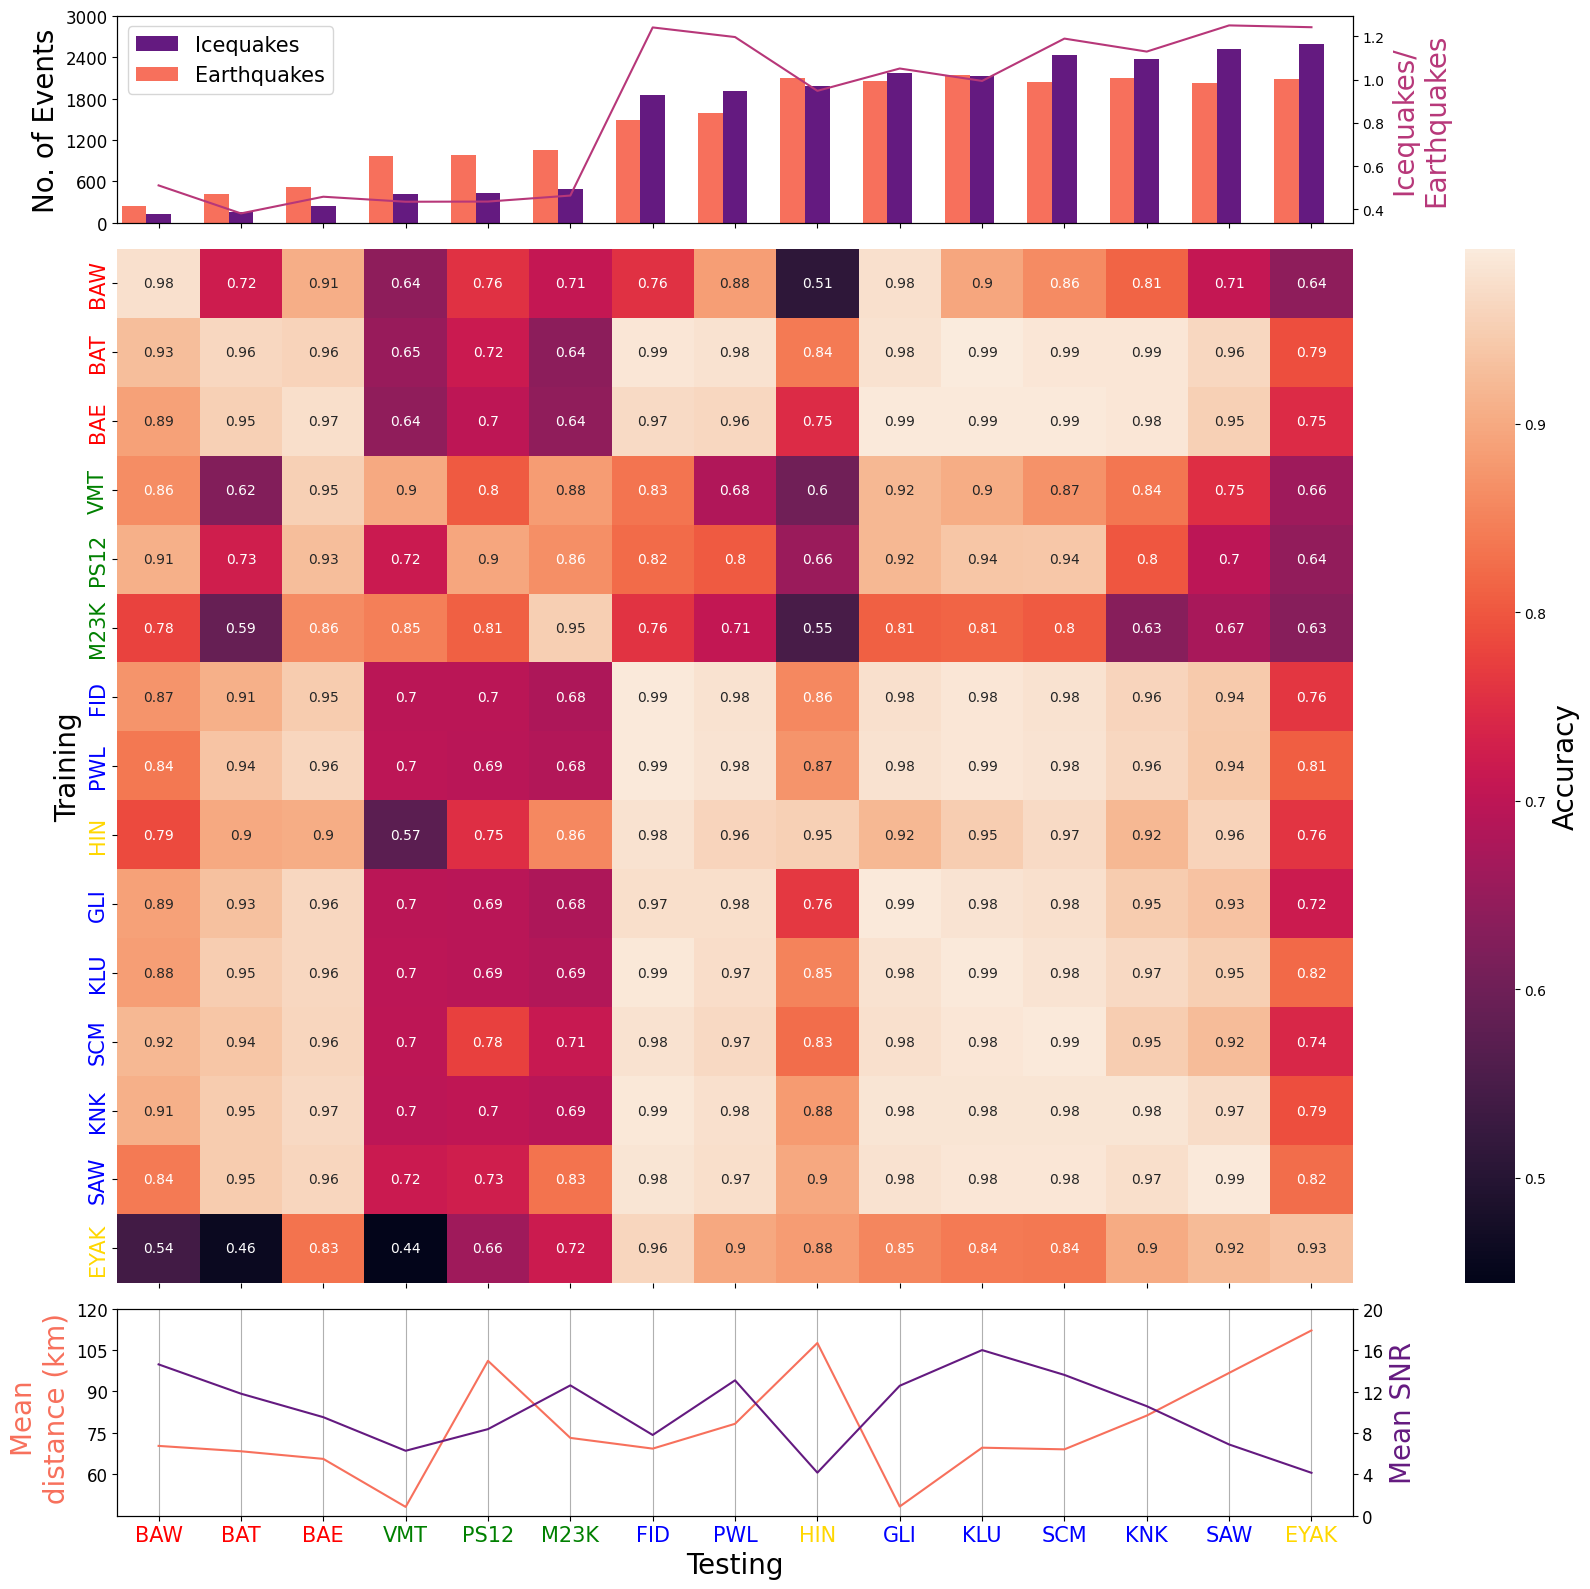

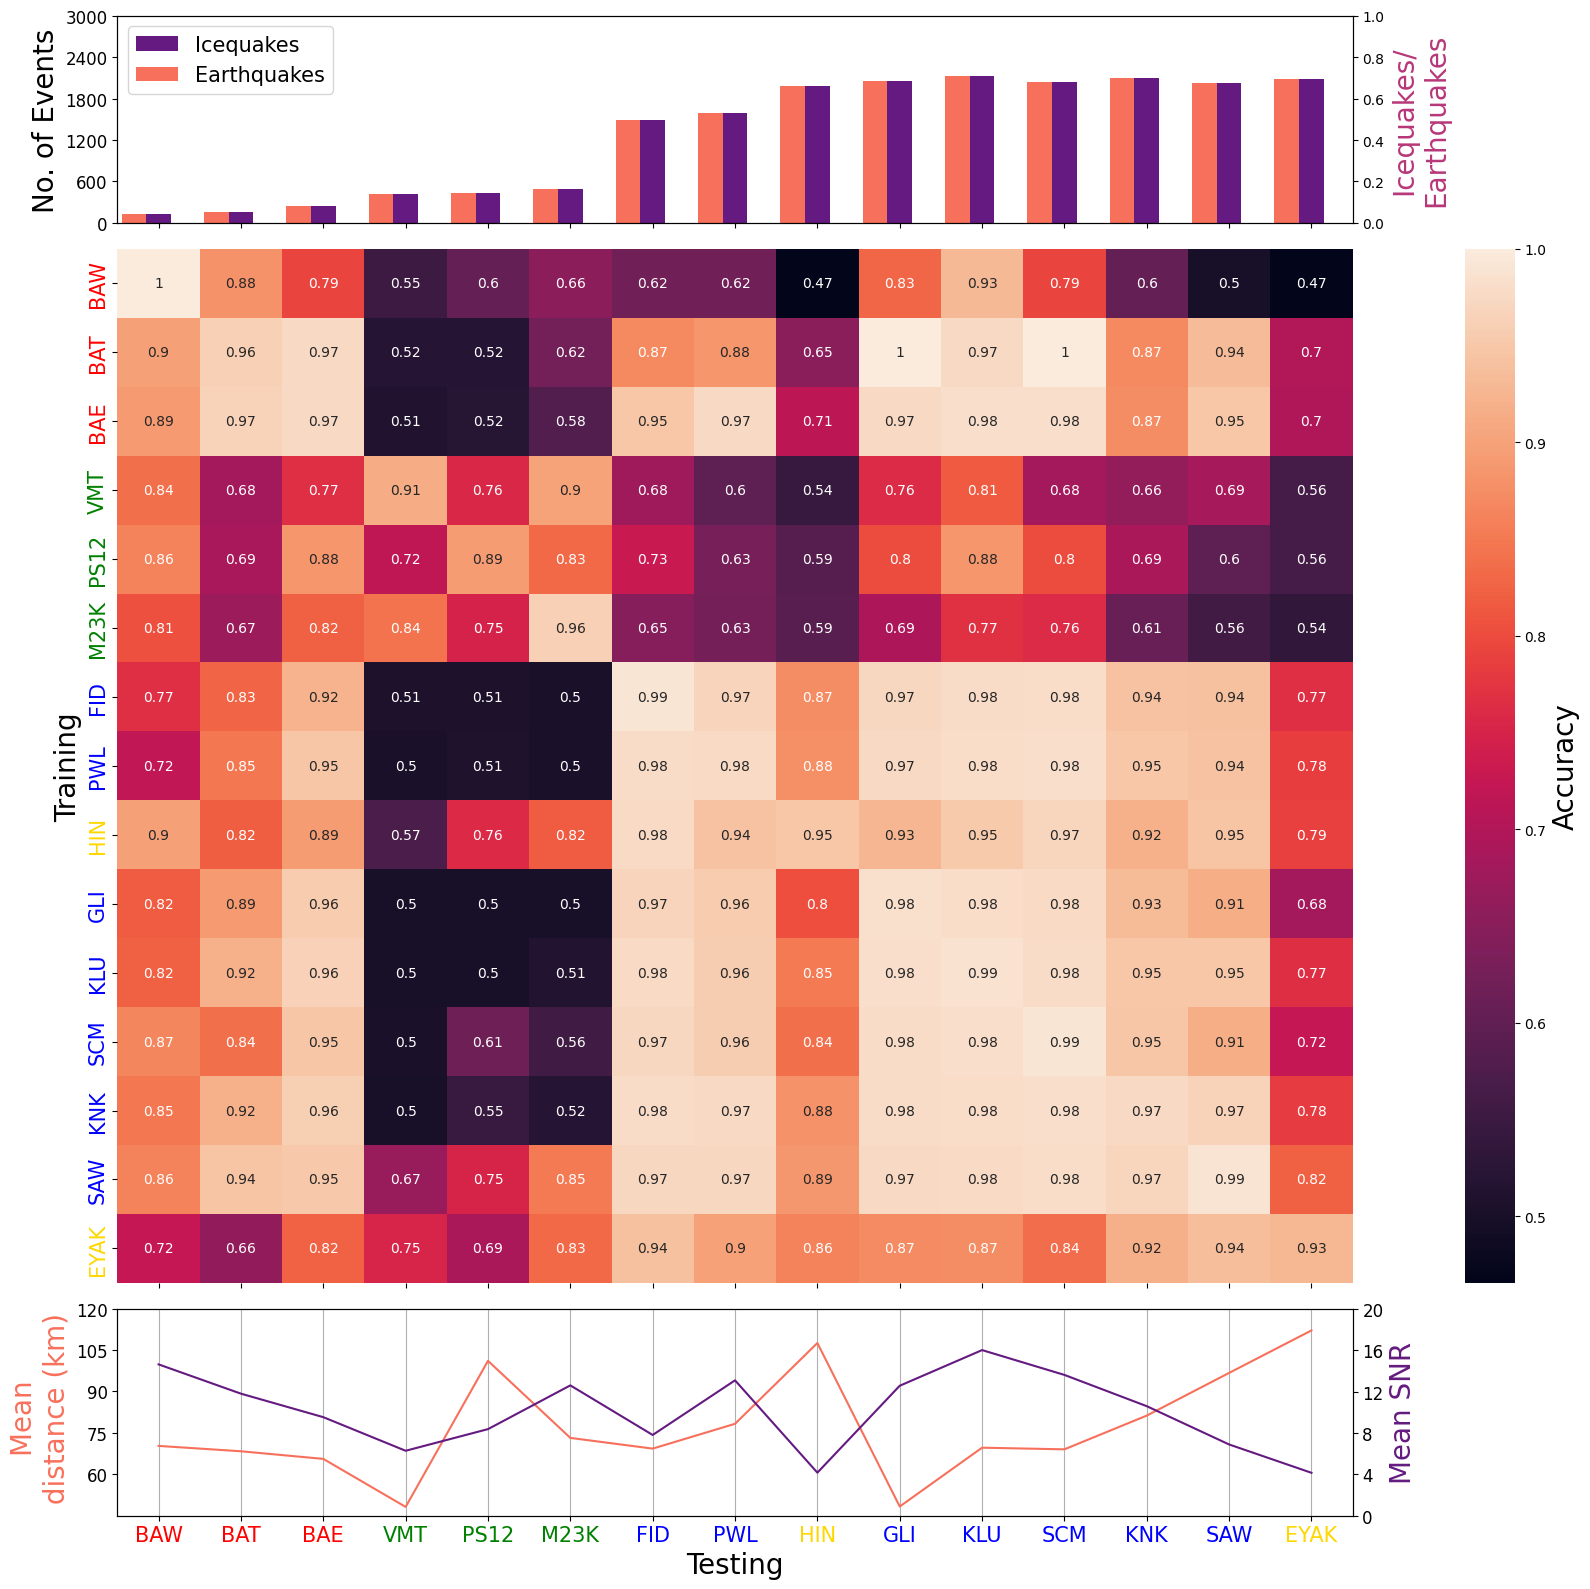

In [33]:
plot_results(acc_order, balanced = False)
plot_results(acc_bal_order, balanced = True)

/tmp/ipykernel_1487308/362835602.py:225: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma')


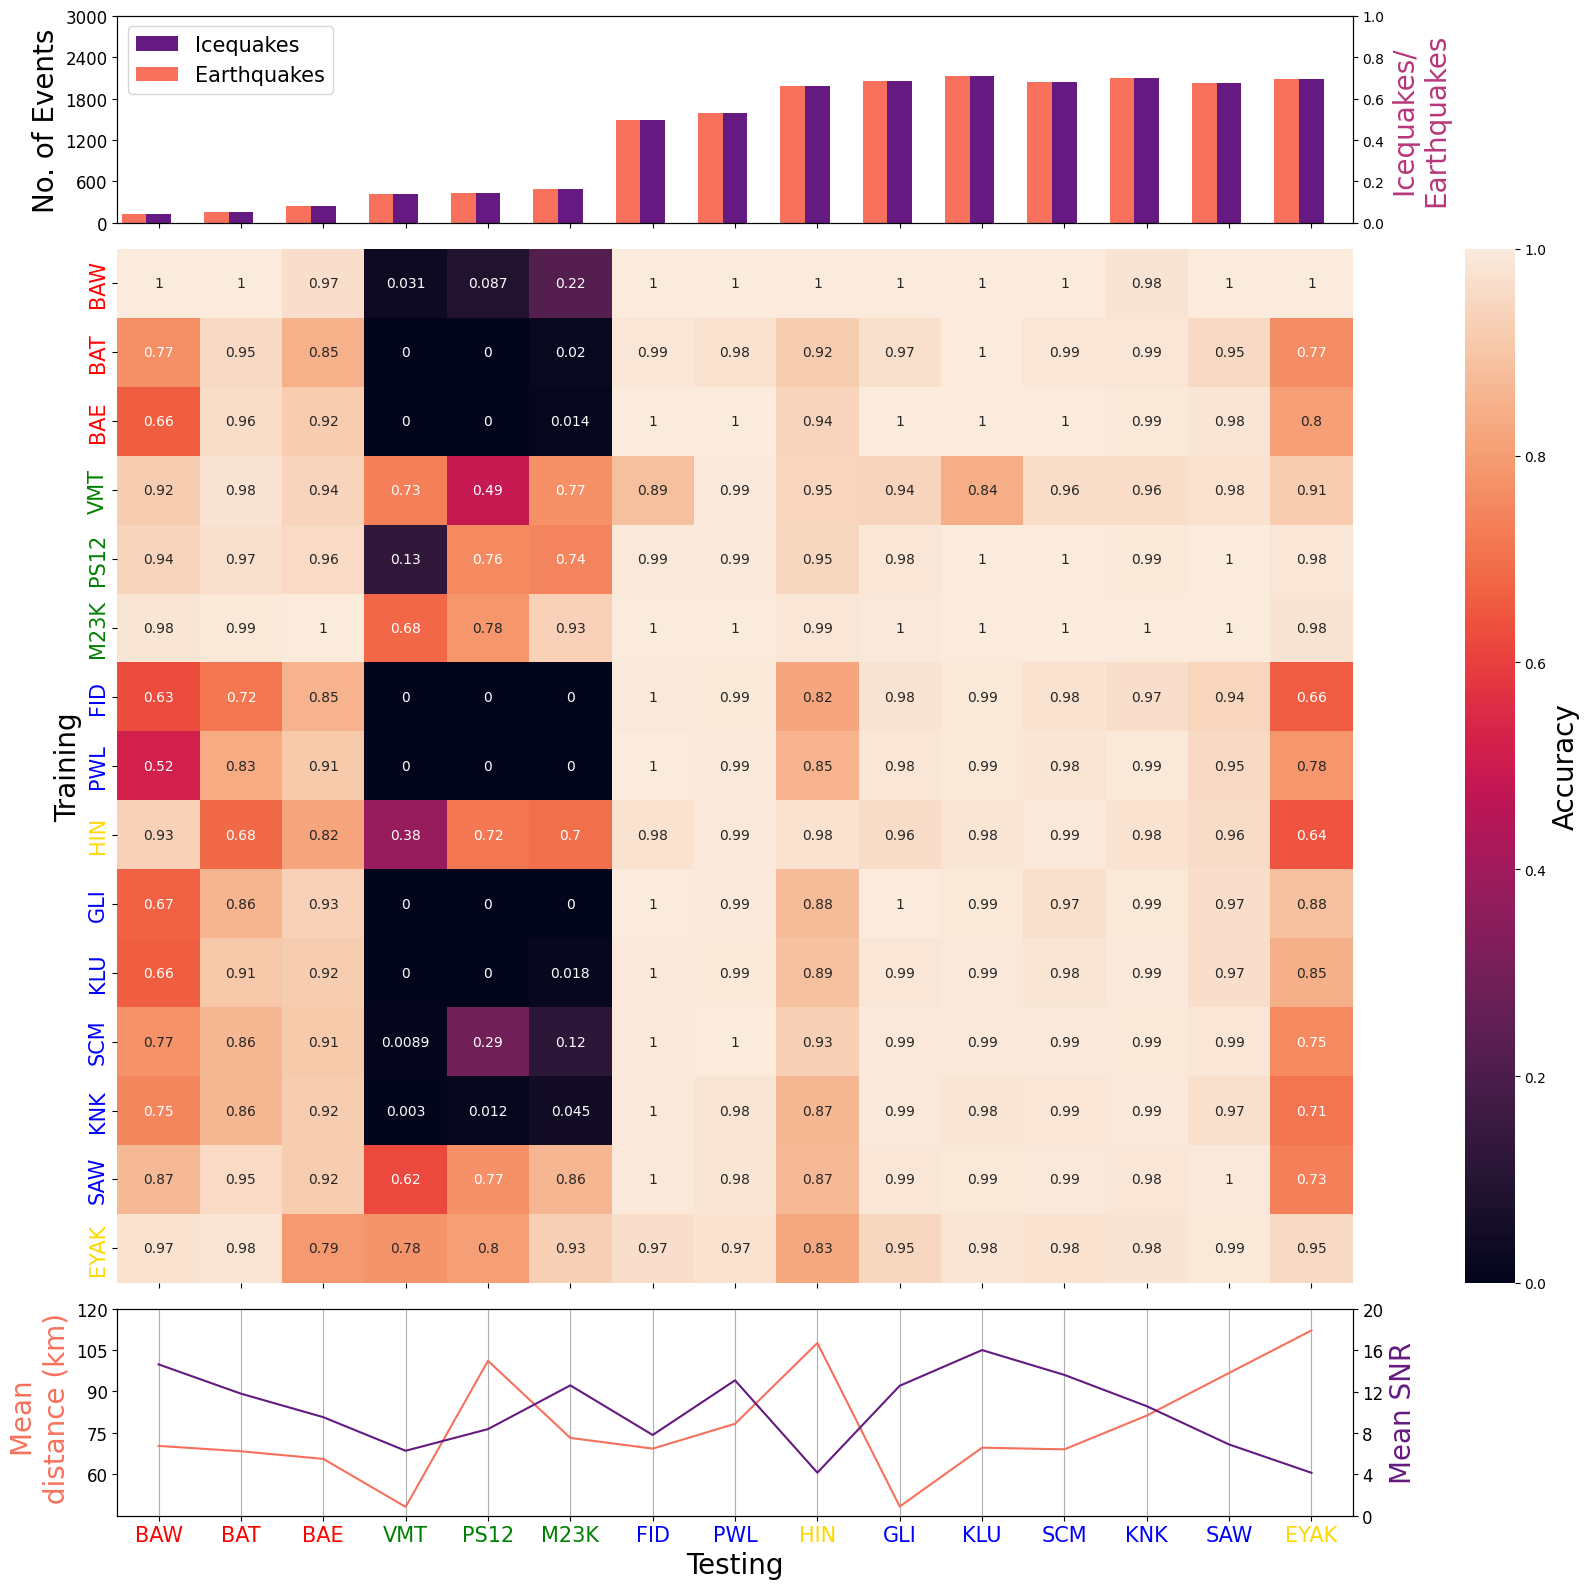

In [34]:
plot_results(sens_order)

/tmp/ipykernel_1487308/362835602.py:225: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('magma')


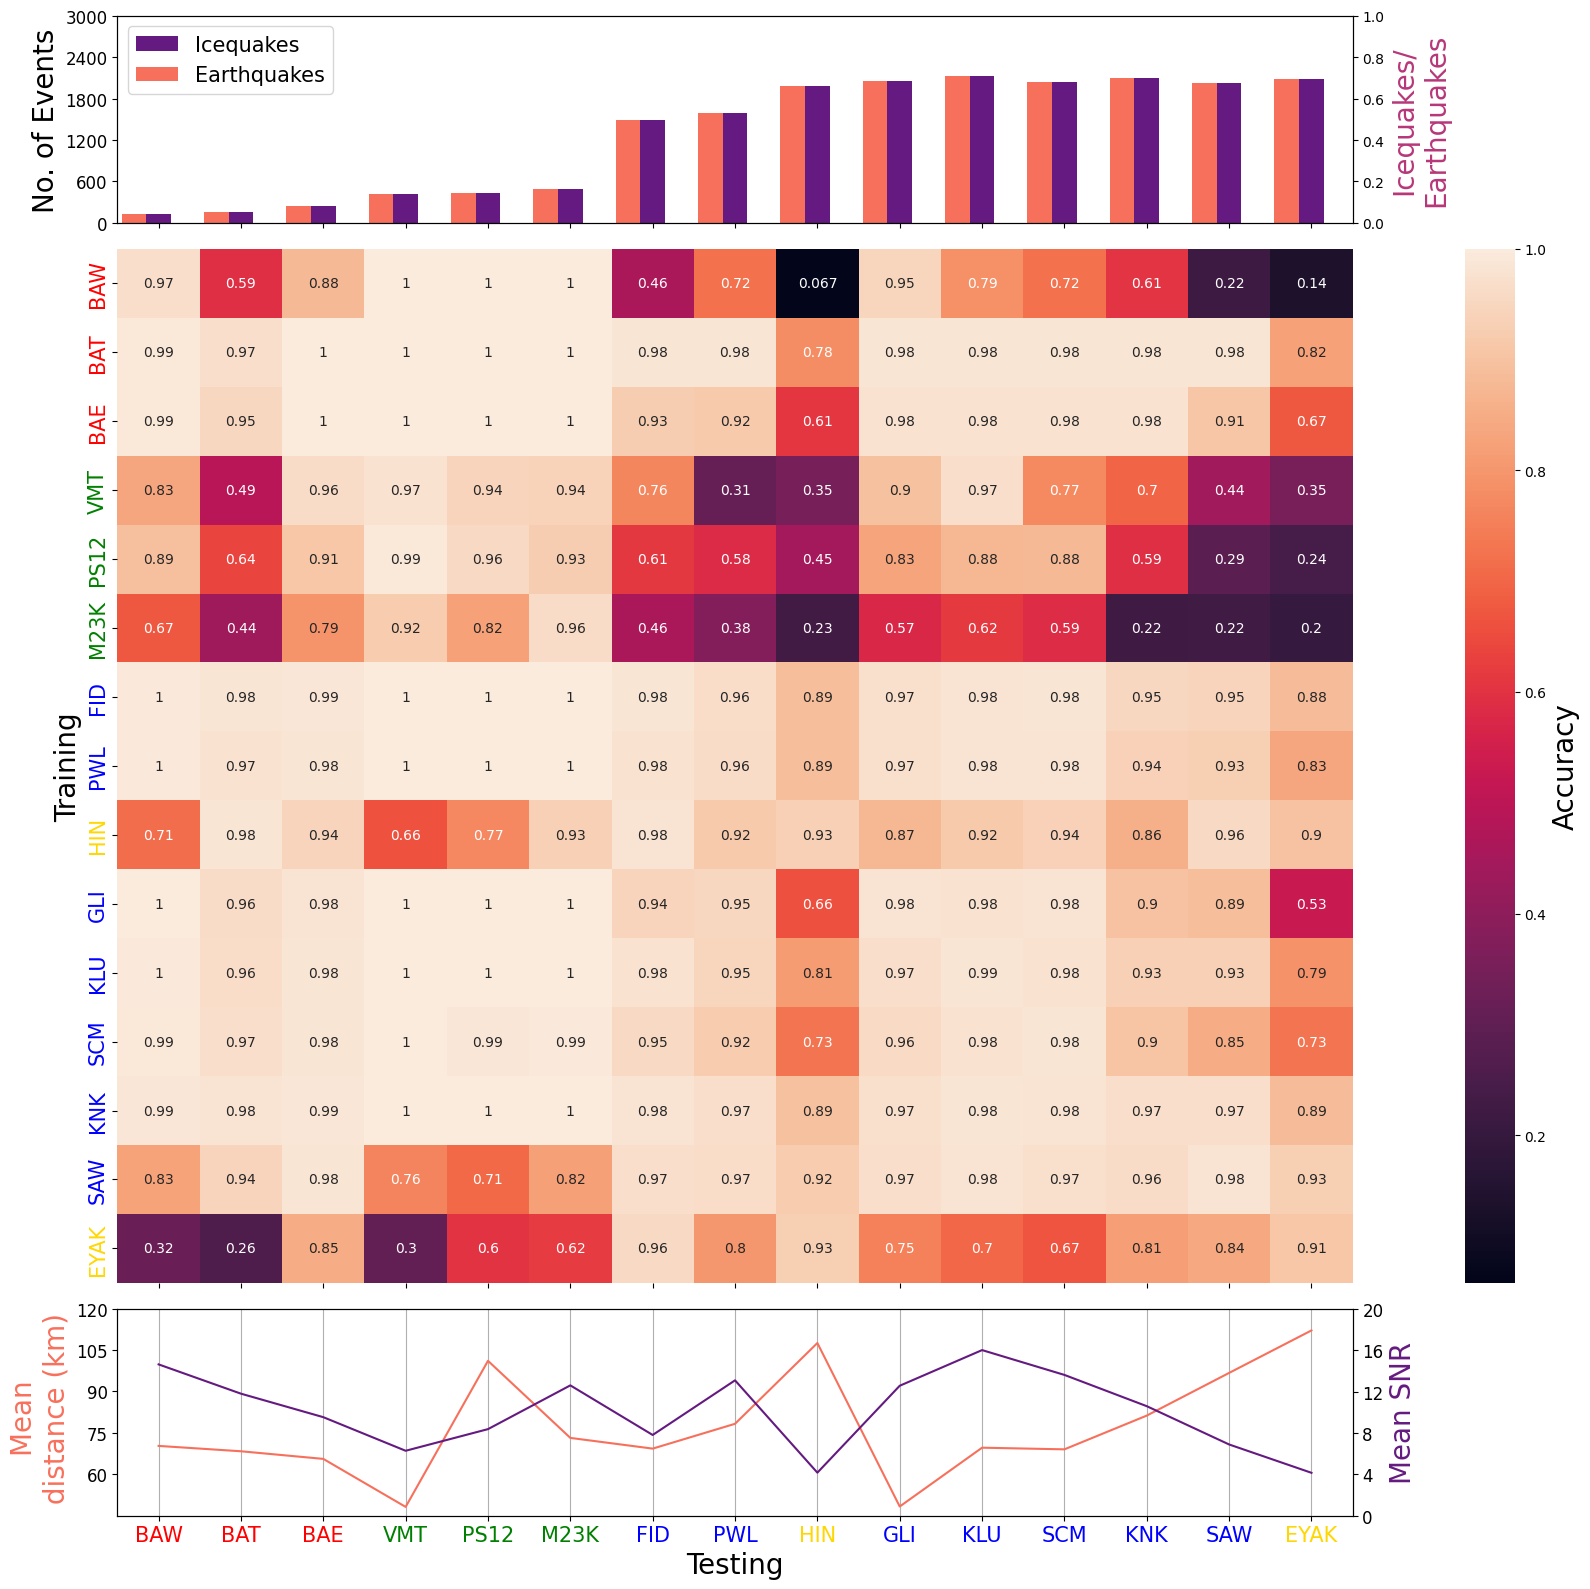

In [35]:
plot_results(spec_order)

## Part 2

## Computing the index of icequakes and earthquakes in each stations to find the earthquakes and icequakes that are common in each station for plotting purpose. 

In [40]:
ind_iq_eq = []
for i in tqdm(range(len(stations))):
    ind_iq_eq.append(compute_ind(stations[i]))

100%|██████████| 15/15 [15:54<00:00, 63.61s/it]


**Extracting icequake and earthquake index from individual stations**

In [41]:
iq_array = [ind_iq_eq[i][0] for i in range(15)]
eq_array = [ind_iq_eq[i][1] for i in range(15)]

**Finding the index of icequakes and earthquakes that were commonly recorded at all the stations**

In [42]:
comm_iq = reduce(np.intersect1d, (iq_array[0], iq_array[1],iq_array[3],iq_array[4],iq_array[5],iq_array[6],
                       iq_array[7],iq_array[8],iq_array[9],iq_array[10],iq_array[11],iq_array[12],
                       iq_array[13],iq_array[14]))

comm_eq = reduce(np.intersect1d, (eq_array[0], eq_array[1],eq_array[3],eq_array[4],eq_array[5],eq_array[6],
                       eq_array[7],eq_array[8],eq_array[9],eq_array[10],eq_array[11],eq_array[12],
                       eq_array[13],eq_array[14]))

**Displaying the index and magnitudes of icequakes**

In [43]:
iq_mag = pd.read_csv('../Catalogs/icequakes_catalog.csv').values[comm_iq][:,4]
eq_mag = pd.read_csv('../Catalogs/earthquakes_catalog.csv').values[comm_eq][:,4]


print('Icequakes')
for i in range(len(comm_iq)):
    print(str(comm_iq[i])+' '+str(iq_mag[i]))
    
print('Earthquakes')
    
for i in range(len(comm_eq)):
    print(str(comm_eq[i])+' '+str(eq_mag[i]))

Icequakes
52 1.4
53 1.4
54 1.1
65 1.1
66 1.5
67 1.1
68 1.3
70 1.5
71 1.2
72 1.0
73 1.1
74 1.3
75 1.3
76 1.4
77 1.4
78 1.5
79 1.6
80 1.3
81 1.3
83 1.3
85 1.1
86 1.5
87 1.3
88 1.3
90 1.4
91 1.6
92 1.1
93 1.3
94 1.0
95 1.3
96 0.9
97 1.2
98 1.0
99 1.1
100 1.4
101 1.4
102 1.3
105 1.1
106 1.2
107 1.2
108 1.2
115 1.4
116 0.8
117 1.3
118 1.0
119 1.0
128 1.3
129 0.9
131 1.1
133 1.4
134 1.0
135 1.4
137 0.9
138 1.1
140 1.3
141 1.1
142 1.2
143 1.3
144 1.4
146 1.5
147 1.1
148 1.3
150 1.1
151 1.4
152 1.3
153 1.2
154 1.0
156 1.4
157 1.1
158 1.2
159 1.3
160 1.3
Earthquakes
418 1.1
433 1.7
501 1.6


In [152]:
stn_new = np.delete(stations,2)
stn_new 


iq_id = 91
eq_id = 433
X_iq = []
X_eq = []
t_iq = []
t_eq = []


dur = 1
for i in range(14):
    st_iq = obspy.read('../Data/icequake_waveforms/icequake'+str(iq_id)+'_'+stn_new[i]+'.mseed').select(channel='BHZ')[0]
    
    network = st_iq.stats.network
    station = st_iq.stats.station
    location = st_iq.stats.location
    channel = st_iq.stats.channel
    starttime = st_iq.stats.starttime
    endtime = st_iq.stats.endtime
    inv = client.get_stations(network = network, station= station, location= location, channel=channel,
             starttime=starttime, endtime=endtime, level="response")

    st_iq.remove_response(inventory= inv, output = "VEL")
    
    st_iq.taper(0.1)
    st_iq.filter('bandpass', freqmin= 1, freqmax=10)
    
    X_iq.append(np.abs(np.fft.fft(st_iq.data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_iq.data[0:int(dur*60*50)])))) 
    t_iq.append(st_iq)
    
    
    
    st_eq = obspy.read('../Data/earthquake_waveforms/earthquake_'+str(eq_id)+'_'+stn_new[i]+'.mseed').select(channel='BHZ')[0]
    network = st_eq.stats.network
    station = st_eq.stats.station
    location = st_eq.stats.location
    channel = st_eq.stats.channel
    starttime = st_eq.stats.starttime
    endtime = st_eq.stats.endtime
    inv = client.get_stations(network = network, station= station, location= location, channel=channel,
             starttime=starttime, endtime=endtime, level="response")

    st_eq.remove_response(inventory= inv, output = "VEL")
    st_eq.taper(0.1)
    st_eq.filter('bandpass', freqmin= 1, freqmax=10)
    t_eq.append(st_eq)
    X_eq.append(np.abs(np.fft.fft(st_eq.data[0:int(dur*60*50)]))/np.max(np.abs(np.fft.fft(st_eq.data[0:int(dur*60*50)]))))  
    
    
val = pd.read_csv('../Catalogs/icequakes_catalog.csv').values[iq_id]
time_iq, lat_iq, lon_iq, depth_iq, mag_iq  = val[0], val[1], val[2], val[3], val[4]

val = pd.read_csv('../Catalogs/earthquakes_catalog.csv').values[eq_id]
time_eq, lat_eq, lon_eq, depth_eq, mag_eq  = val[0], val[1], val[2], val[3], val[4]

In [153]:
dists_iq = []

for i in range(len(t_iq)):
    
    stn_lat = stns[stns[' Station '] == t_iq[i].stats.station].values[0][2]
    stn_lon = stns[stns[' Station '] == t_iq[i].stats.station].values[0][3]
    dists_iq.append(gps2dist_azimuth(stn_lat, stn_lon, lat_iq, lon_iq)[0]/1000)
    
dists_eq = []

for i in range(len(t_eq)):
    
    stn_lat = stns[stns[' Station '] == t_eq[i].stats.station].values[0][2]
    stn_lon = stns[stns[' Station '] == t_eq[i].stats.station].values[0][3]
    dists_eq.append(gps2dist_azimuth(stn_lat, stn_lon, lat_eq, lon_eq)[0]/1000)

In [154]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['font.weight'] = 'bold'

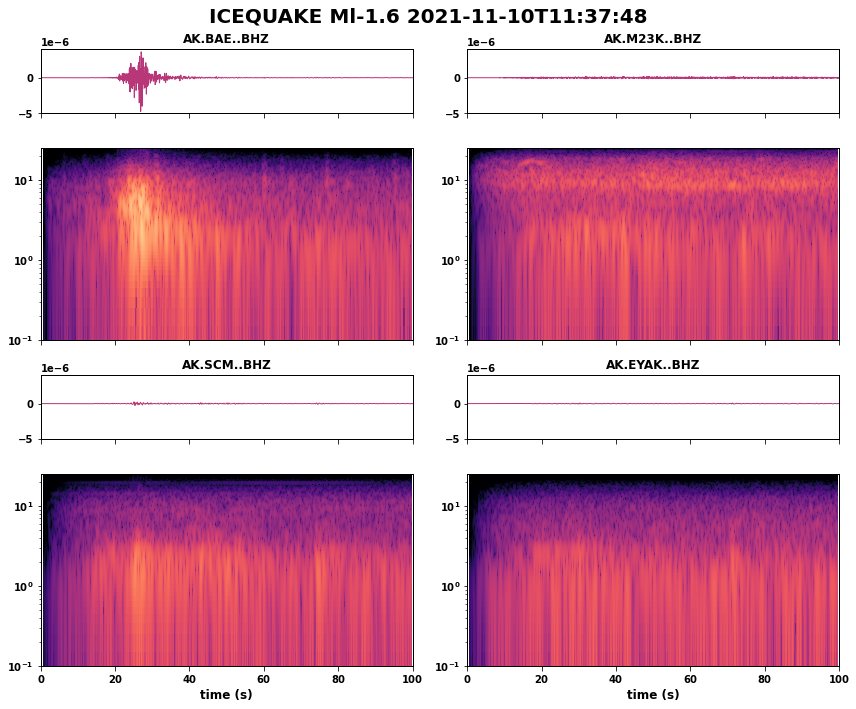

In [155]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,3,1,3], 'width_ratios':[1,1]})



l1 = 0.1
l2 = 25
time = t_iq[0].times()
ax[0][0].plot(time, t_iq[0].data, lw= 1, color = c3)
#ax[0][0].set_ylim(-500,500)
ax[0][0].set_xlim(0,100)

ax[0][0].set_title(t_iq[0].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
ax[1][0].set_xlim(0,100)
ax[1][0].set_ylim(l1,l2)
ax[1][0].set_yscale('log')

im = yax.images[0]
#print(im.get_clim())
im.set_clim(vmin=-250,vmax= -100)



ax[0][1].plot(time, t_iq[8].data, lw = 1, color = c3)
#ax[0][1].set_ylim(-500,500)
ax[0][1].set_xlim(0,100)
ax[0][1].set_title(t_iq[8].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[8].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
ax[1][1].set_xlim(0,100)
ax[1][1].set_ylim(l1,l2)
ax[1][1].set_yscale('log')
im = yax.images[0]
im.set_clim(vmin=-250,vmax= -100)



ax[2][0].plot(time, t_iq[12].data, lw = 1, color = c3)
#ax[2][0].set_ylim(-500,500)
ax[2][0].set_xlim(0,100)
ax[2][0].set_title(t_iq[12].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
ax[3][0].set_xlim(0,100)
ax[3][0].set_ylim(l1,l2)
ax[3][0].set_yscale('log')
ax[3][0].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
im = yax.images[0]
im.set_clim(vmin=-250,vmax=-100)



ax[2][1].plot(time, t_iq[2].data, lw = 1, color = c3)
#ax[2][1].set_ylim(-500,500)
ax[2][1].set_xlim(0,100)
ax[2][1].set_title(t_iq[2].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
ax[3][1].set_xlim(0,100)
ax[3][1].set_ylim(l1,l2)
ax[3][1].set_yscale('log')
ax[3][1].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
im = yax.images[0]
im.set_clim(vmin=-250,vmax=-100)


y1 = -5e-6
y2 = 4e-6

ax[0][0].set_ylim(y1, y2)
ax[0][1].set_ylim(y1, y2)
ax[2][0].set_ylim(y1, y2)
ax[2][1].set_ylim(y1, y2)


fig.suptitle('ICEQUAKE'+' Ml-'+str(mag_iq)+' '+str(time_iq)[0:19], fontsize = 20, fontweight='bold')
#fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

In [ ]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,3,1,3], 'width_ratios':[1,1]})



l1 = 0.1
l2 = 25
time = t_iq[0].times()
ax[0][0].plot(time, t_iq[0].data, lw= 1, color = c3)
#ax[0][0].set_ylim(-500,500)
ax[0][0].set_xlim(0,100)

ax[0][0].set_title(t_iq[0].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
ax[1][0].set_xlim(0,100)
ax[1][0].set_ylim(l1,l2)
ax[1][0].set_yscale('log')

im = yax.images[0]
#print(im.get_clim())
im.set_clim(vmin=-250,vmax= -100)



ax[0][1].plot(time, t_iq[8].data, lw = 1, color = c3)
#ax[0][1].set_ylim(-500,500)
ax[0][1].set_xlim(0,100)
ax[0][1].set_title(t_iq[8].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[8].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
ax[1][1].set_xlim(0,100)
ax[1][1].set_ylim(l1,l2)
ax[1][1].set_yscale('log')
im = yax.images[0]
im.set_clim(vmin=-250,vmax= -100)



ax[2][0].plot(time, t_iq[12].data, lw = 1, color = c3)
#ax[2][0].set_ylim(-500,500)
ax[2][0].set_xlim(0,100)
ax[2][0].set_title(t_iq[12].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
ax[3][0].set_xlim(0,100)
ax[3][0].set_ylim(l1,l2)
ax[3][0].set_yscale('log')
ax[3][0].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
im = yax.images[0]
im.set_clim(vmin=-250,vmax=-100)



ax[2][1].plot(time, t_iq[2].data, lw = 1, color = c3)
#ax[2][1].set_ylim(-500,500)
ax[2][1].set_xlim(0,100)
ax[2][1].set_title(t_iq[2].id, fontsize = 12, fontweight = 'bold')
yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
ax[3][1].set_xlim(0,100)
ax[3][1].set_ylim(l1,l2)
ax[3][1].set_yscale('log')
ax[3][1].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
im = yax.images[0]
im.set_clim(vmin=-250,vmax=-100)


y1 = -5e-6
y2 = 4e-6

ax[0][0].set_ylim(y1, y2)
ax[0][1].set_ylim(y1, y2)
ax[2][0].set_ylim(y1, y2)
ax[2][1].set_ylim(y1, y2)


fig.suptitle('ICEQUAKE'+' Ml-'+str(mag_iq)+' '+str(time_iq)[0:19], fontsize = 20, fontweight='bold')
#fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

In [156]:
ax[0][0].get_ylim()

(-5.0000000000000004e-06, 3.9999999999999998e-06)

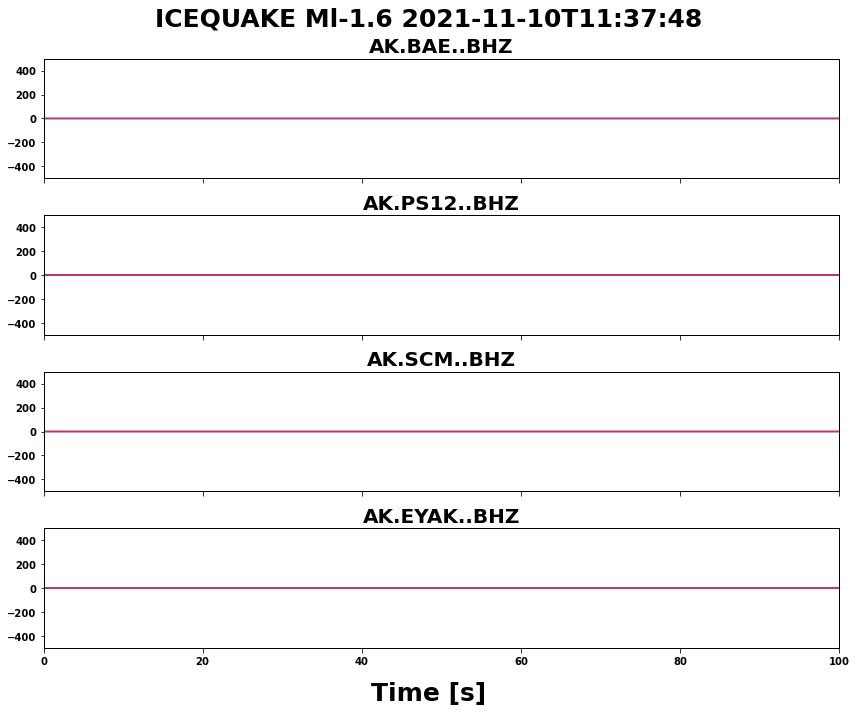

In [157]:
fig, ax= plt.subplots(nrows=4, ncols=1, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,1,1,1]})



l1 = 0
l2 = 25
time = t_iq[0].times()
ax[0].plot(time, t_iq[0].data, lw=2, color = c3)
ax[0].set_ylim(-500,500)
ax[0].set_xlim(0,100)
ax[0].set_title(t_iq[0].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
#ax[1][0].set_xlim(0,100)
#ax[1][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[1].plot(time, t_iq[9].data, lw = 2, color = c3)
ax[1].set_ylim(-500,500)
ax[1].set_xlim(0,100)
ax[1].set_title(t_iq[9].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
#ax[1][1].set_xlim(0,100)
#ax[1][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[2].plot(time, t_iq[12].data, lw = 2, color = c3)
ax[2].set_ylim(-500,500)
ax[2].set_xlim(0,100)
ax[2].set_title(t_iq[12].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
#ax[3][0].set_xlim(0,100)
#ax[3][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[3].plot(time, t_iq[2].data, lw = 2, color = c3)
ax[3].set_ylim(-500,500)
ax[3].set_xlim(0,100)
ax[3].set_title(t_iq[2].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
#ax[3][1].set_xlim(0,100)
#ax[3][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



fig.suptitle('ICEQUAKE'+' Ml-'+str(mag_iq)+' '+str(time_iq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

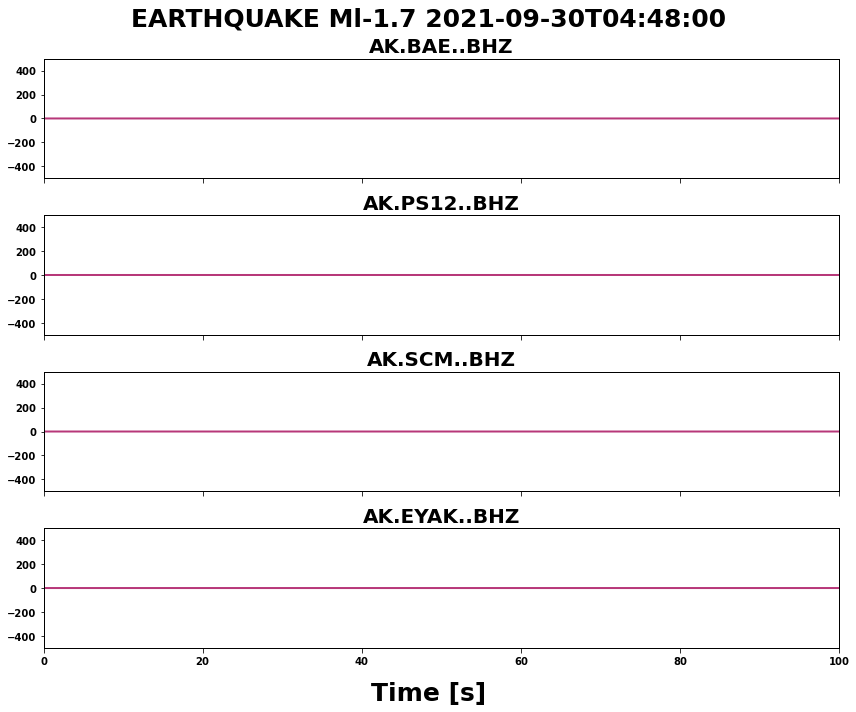

In [158]:
fig, ax= plt.subplots(nrows=4, ncols=1, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,1,1,1]})



l1 = 0
l2 = 25
time = t_eq[0].times()
ax[0].plot(time, t_eq[0].data, lw=2, color = c3)
ax[0].set_ylim(-500,500)
ax[0].set_xlim(0,100)
ax[0].set_title(t_eq[0].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
#ax[1][0].set_xlim(0,100)
#ax[1][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[1].plot(time, t_eq[9].data, lw = 2, color = c3)
ax[1].set_ylim(-500,500)
ax[1].set_xlim(0,100)
ax[1].set_title(t_eq[9].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
#ax[1][1].set_xlim(0,100)
#ax[1][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[2].plot(time, t_eq[12].data, lw = 2, color = c3)
ax[2].set_ylim(-500,500)
ax[2].set_xlim(0,100)
ax[2].set_title(t_eq[12].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
#ax[3][0].set_xlim(0,100)
#ax[3][0].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



ax[3].plot(time, t_eq[2].data, lw = 2, color = c3)
ax[3].set_ylim(-500,500)
ax[3].set_xlim(0,100)
ax[3].set_title(t_eq[2].id, fontsize = 20, fontweight = 'bold')
#yax = t_iq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
#ax[3][1].set_xlim(0,100)
#ax[3][1].set_ylim(l1,l2)
#im = yax.images[0]
#im.set_clim(vmin=-10,vmax=30)



fig.suptitle('EARTHQUAKE'+' Ml-'+str(mag_eq)+' '+str(time_eq)[0:19], fontsize = 25, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 25, fontweight = 'bold')
fig.tight_layout()

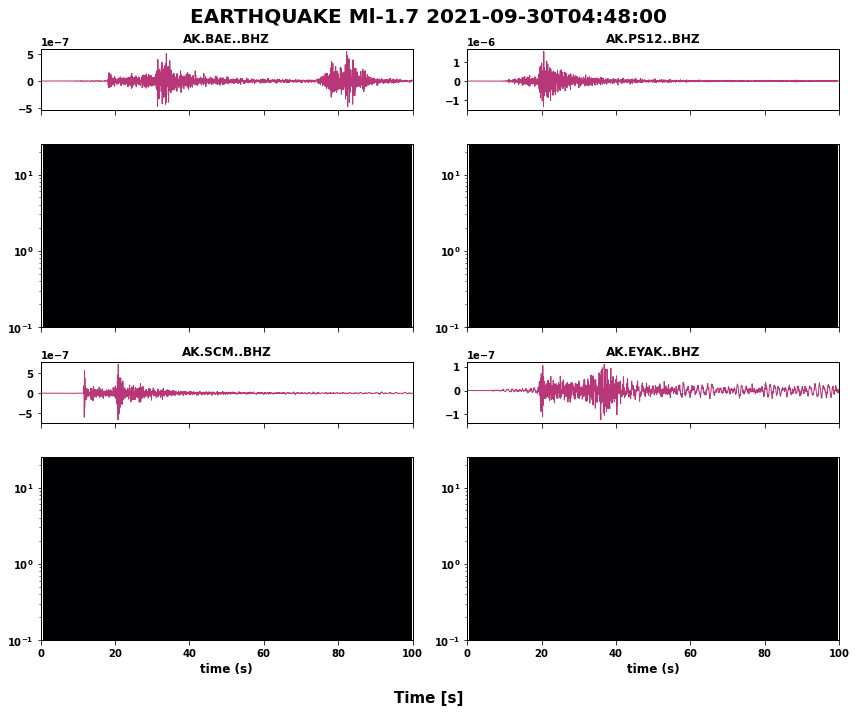

In [159]:
fig, ax= plt.subplots(nrows=4, ncols=2, figsize=(12,10), sharex='col', gridspec_kw=
                                                   {'height_ratios':[1,3,1,3], 'width_ratios':[1,1]})


l1 = 0.1
l2 = 25

ax[0][0].plot(time, t_eq[0].data, lw=1, color = c3)
#ax[0][0].set_ylim(-500,500)
ax[0][0].set_xlim(0,100)
ax[0][0].set_title(t_eq[0].id, fontsize = 12, fontweight = 'bold')
yax = t_eq[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][0])
ax[1][0].set_xlim(0,100)
ax[1][0].set_ylim(l1,l2)
ax[1][0].set_yscale('log')
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[0][1].plot(time, t_eq[9].data, lw = 1, color = c3)
#ax[0][1].set_ylim(-500,500)
ax[0][1].set_xlim(0,100)
ax[0][1].set_title(t_eq[9].id, fontsize = 12, fontweight = 'bold')
yax = t_eq[9].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[1][1])
ax[1][1].set_xlim(0,100)
ax[1][1].set_ylim(l1,l2)
ax[1][1].set_yscale('log')
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[2][0].plot(time, t_eq[12].data, lw = 1, color = c3)
#ax[2][0].set_ylim(-500,500)
ax[2][0].set_xlim(0,100)
ax[2][0].set_title(t_eq[12].id, fontsize = 12, fontweight = 'bold')
yax = t_eq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])
ax[3][0].set_xlim(0,100)
ax[3][0].set_ylim(l1,l2)
ax[3][0].set_yscale('log')
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)

ax[2][1].plot(time, t_eq[2].data, lw = 1, color = c3)
#ax[2][1].set_ylim(-500,500)
ax[2][1].set_xlim(0,100)
ax[2][1].set_title(t_eq[2].id, fontsize = 12, fontweight = 'bold')
yax = t_eq[2].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][1], clip = (0.2,1))
ax[3][1].set_xlim(0,100)
ax[3][1].set_ylim(l1,l2)
ax[3][1].set_yscale('log')
ax[3][0].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
ax[3][1].set_xlabel('time (s)', fontsize = 12, fontweight = 'bold')
im = yax.images[0]
im.set_clim(vmin=-10,vmax=30)



fig.suptitle('EARTHQUAKE'+' Ml-'+str(mag_eq)+' '+str(time_eq)[0:19], fontsize = 20, fontweight='bold')
fig.supxlabel('Time [s]', fontsize = 15, fontweight = 'bold')
fig.tight_layout()

## Plotting the above events on the map

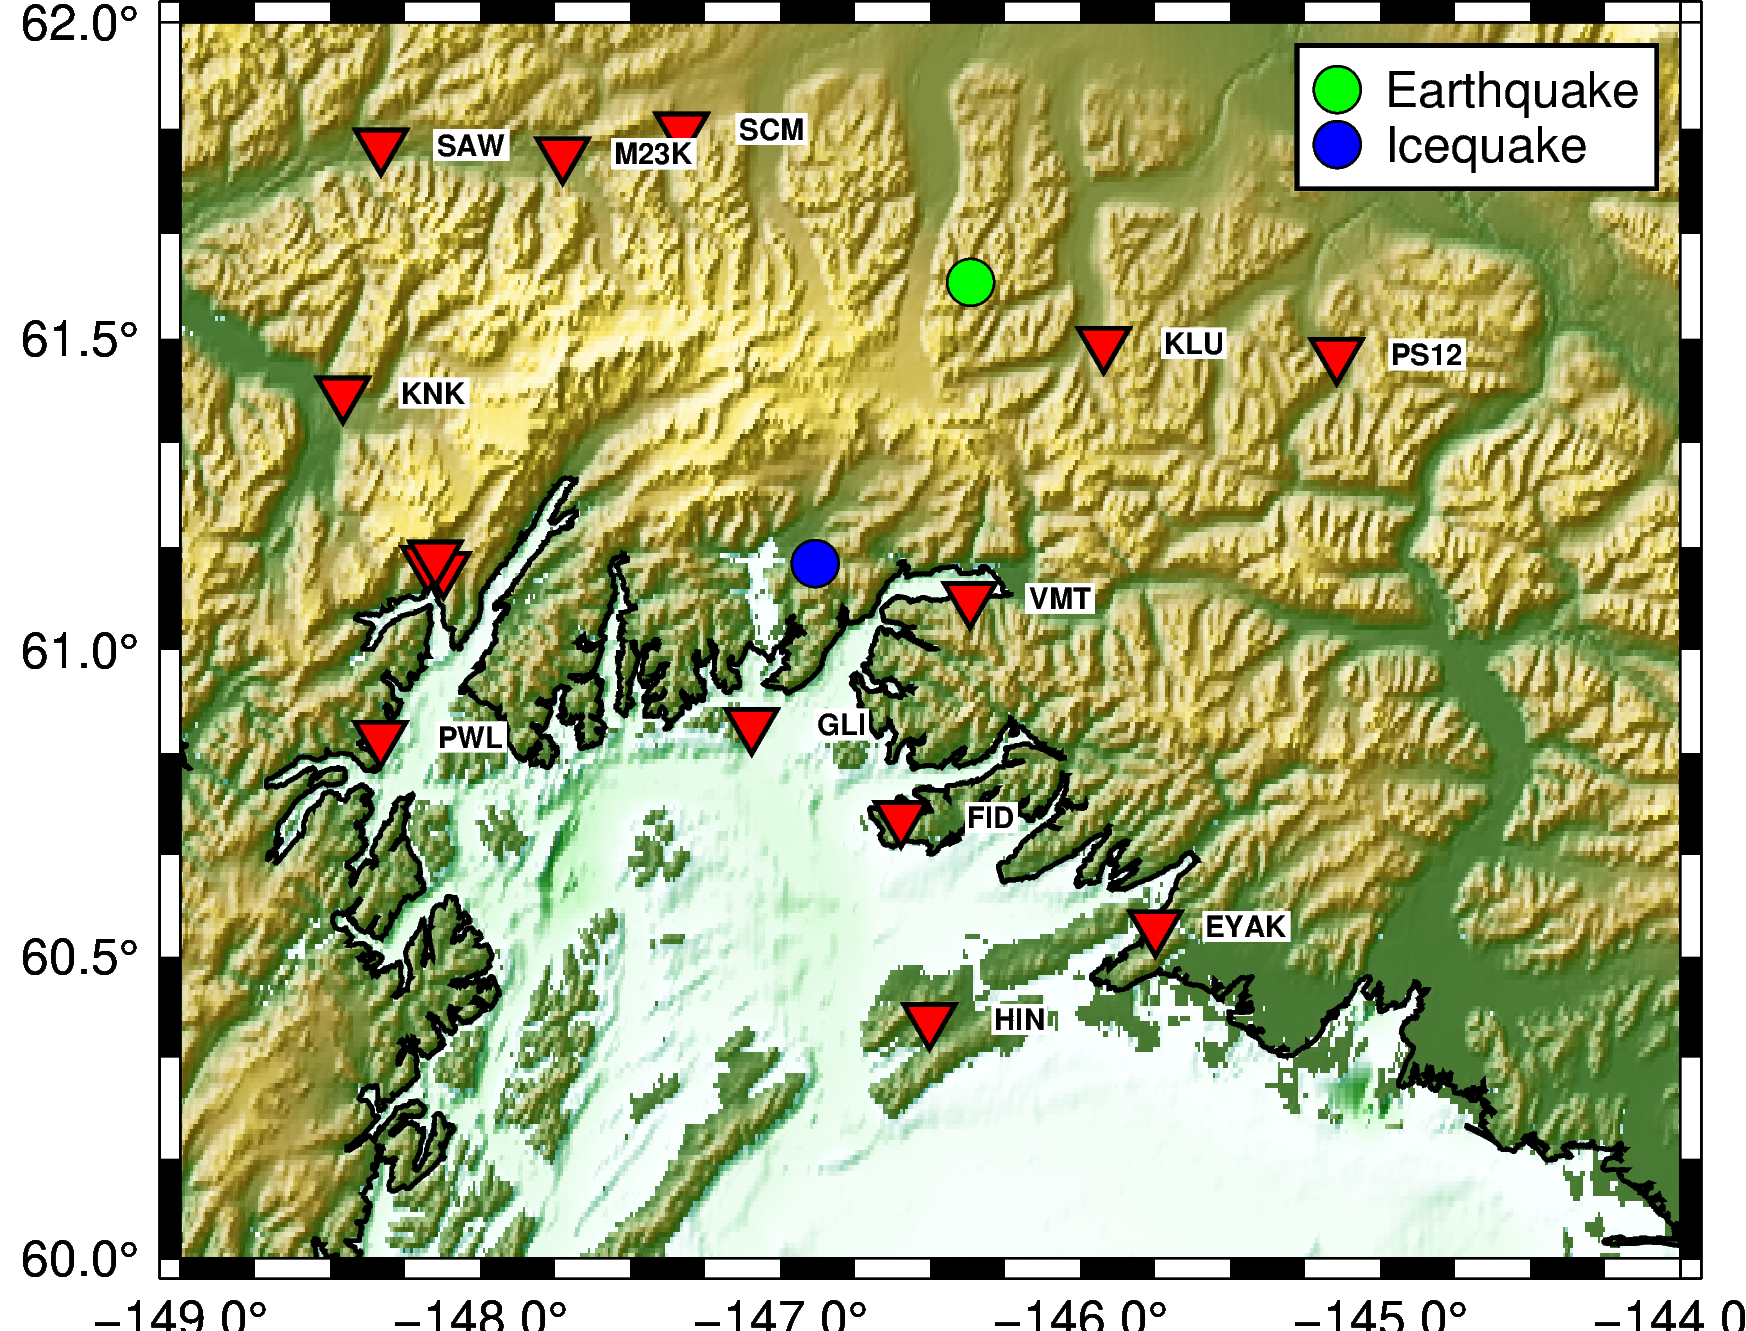

In [160]:
region = [-149.0, -144, 60, 62]
fig = pygmt.Figure()
pygmt.makecpt(cmap='relief',series='-5000/5000/1000',continuous=True)
topo_data = '@earth_relief_30s'
pygmt.config(FORMAT_GEO_MAP="ddd.x")
fig.grdimage(grid=topo_data,region=region,projection='M5i',shading=True,cmap=True,
            frame=["WSne", "xaf", "yaf"])
#pygmt.makecpt(cmap="plasma", series=[np.min(depths),25])
fig.coast(area_thresh = 10000,
    shorelines='1p,black',
#          water="lightblue",
          region=region,
#          borders="1/thick",
         frame=["WSne", "xaf", "yaf"], )

#fig.colorbar(frame='af+l"Elevation(m)"')
pygmt.makecpt(cmap="plasma", series = [70,100])

fig.plot(x=lon_eq,y=lat_eq,style='c0.4c',color='green',pen='0.5p,black',
         region=region, label='Earthquake')
fig.plot(x=lon_iq,y=lat_iq,style='c0.4c',color='blue',pen='0.5p,black',
         region=region, label='Icequake')
fig.plot(x=stn_lons, y=stn_lats,style='i0.5c',color='red',pen='1p,black',
         region=region, cmap=False)
#fig.plot(x=gl_lons,y=gl_lats,style='a0.6c',color='yellow',pen='0.5p,black',
#         region=region)
#fig.text(text=glaciers, y=gl_lats, x=np.array(gl_lons)+0.2,font="7p,Helvetica-Bold,black",fill='white')
fig.text(text=stations[3:],y=stn_lats[3:]+0.00,x=stn_lons[3:]+0.30,font="7p,Helvetica-Bold,black",fill='white')
fig.legend()



fig.show()

## Further Experimenting on the plots

/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9/site-packages/obspy/signal/filter.py:67: UserWarning: Selected high corner frequency (25) of bandpass is at or above Nyquist (25.0). Applying a high-pass instead.
  warnings.warn(msg)
/home/ak287/miniconda3/envs/roses_2021/lib/python3.9

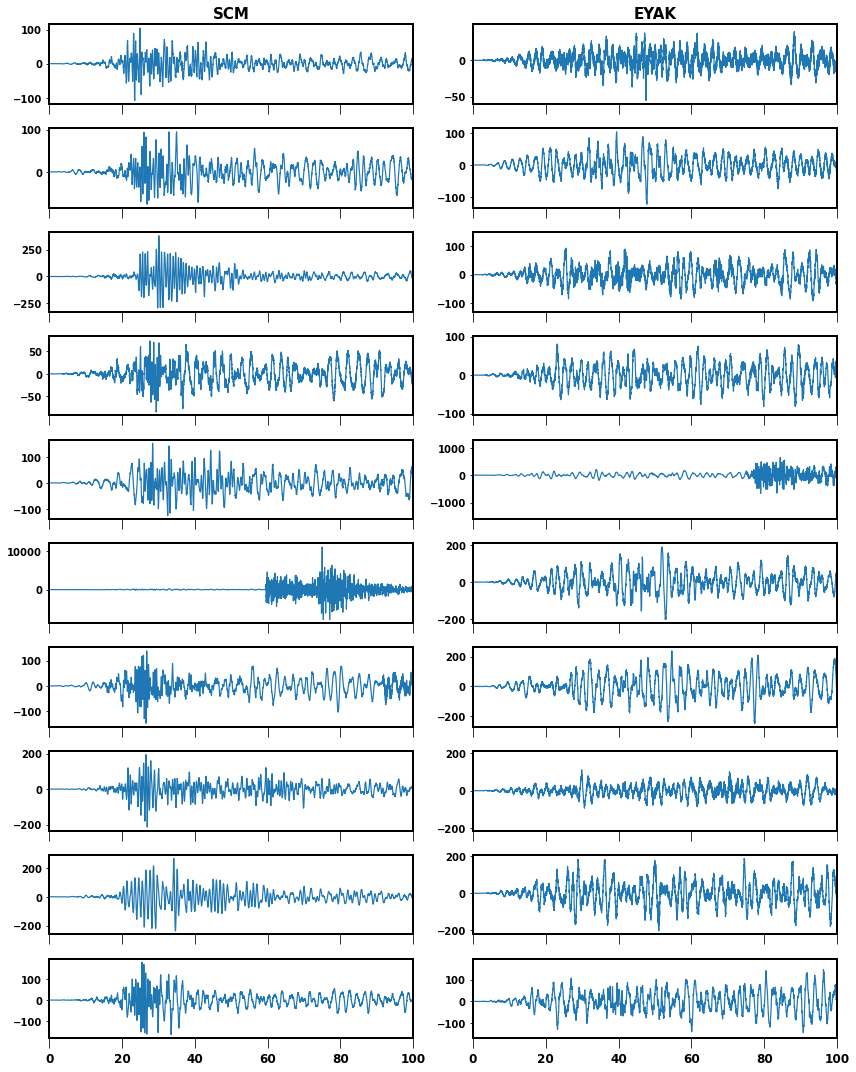

In [122]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'SCM'
x = random.sample(range(100), 10)
r = np.array(glob('../Data/icequake_waveforms/*'+station+'*'))[x]

station1 = 'EYAK'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('../Data/icequake_waveforms/*'+station1+'*'))[x]



for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=25)
    time = st[0].times()
    ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    #ax[i][0].set_ylim(-500,500)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    

    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=25)
    time = st1[0].times()
    ax[i][1].plot(time, st1[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    #ax[i][1].set_ylim(-500,500)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
    
    
    
fig.tight_layout()

In [120]:
t_eq[12].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[3][0])

<AxesSubplot:>

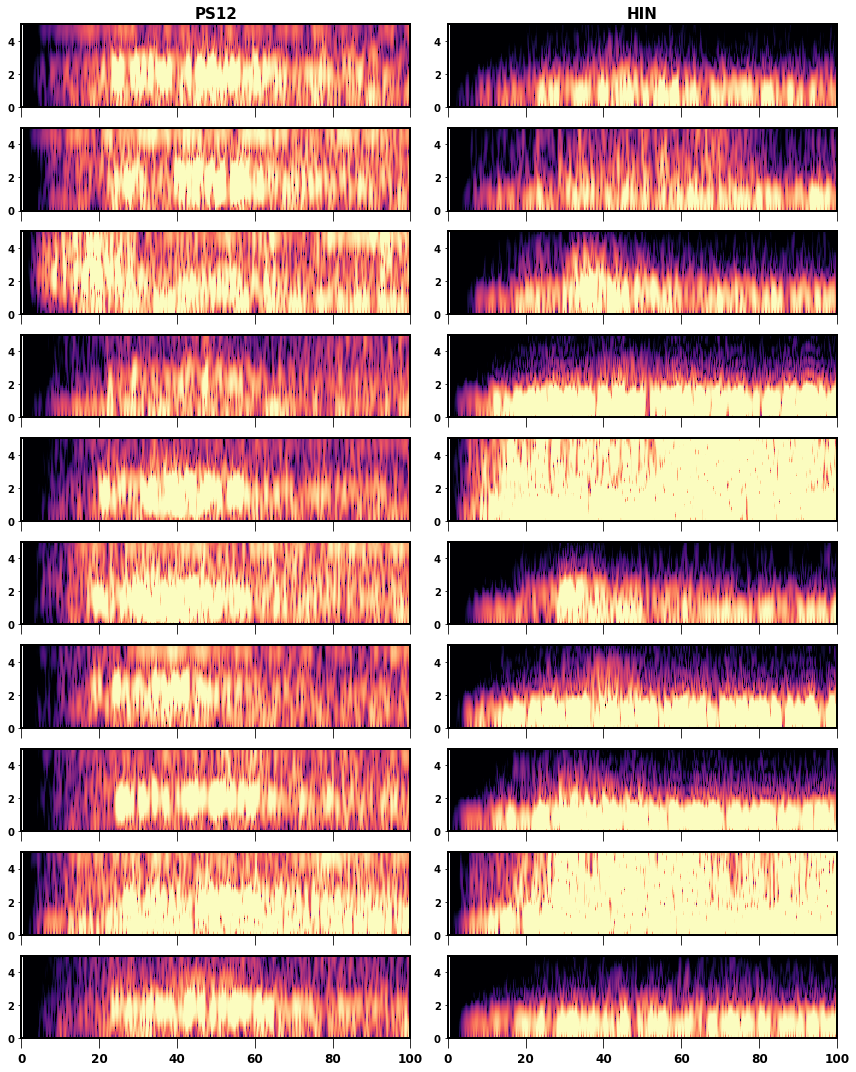

In [123]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'PS12'
x = random.sample(range(100), 10)
r = np.array(glob('../Data/icequake_waveforms/*'+station+'*'))[x]


station1 = 'HIN'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('../Data/icequake_waveforms/*'+station1+'*'))[x1]


for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st[0].times()
    yax = st[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][0])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    ax[i][0].set_ylim(0,5)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    
    
    
    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st1[0].times()
    yax = st1[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][1])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    ax[i][1].set_ylim(0,5)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
fig.tight_layout()

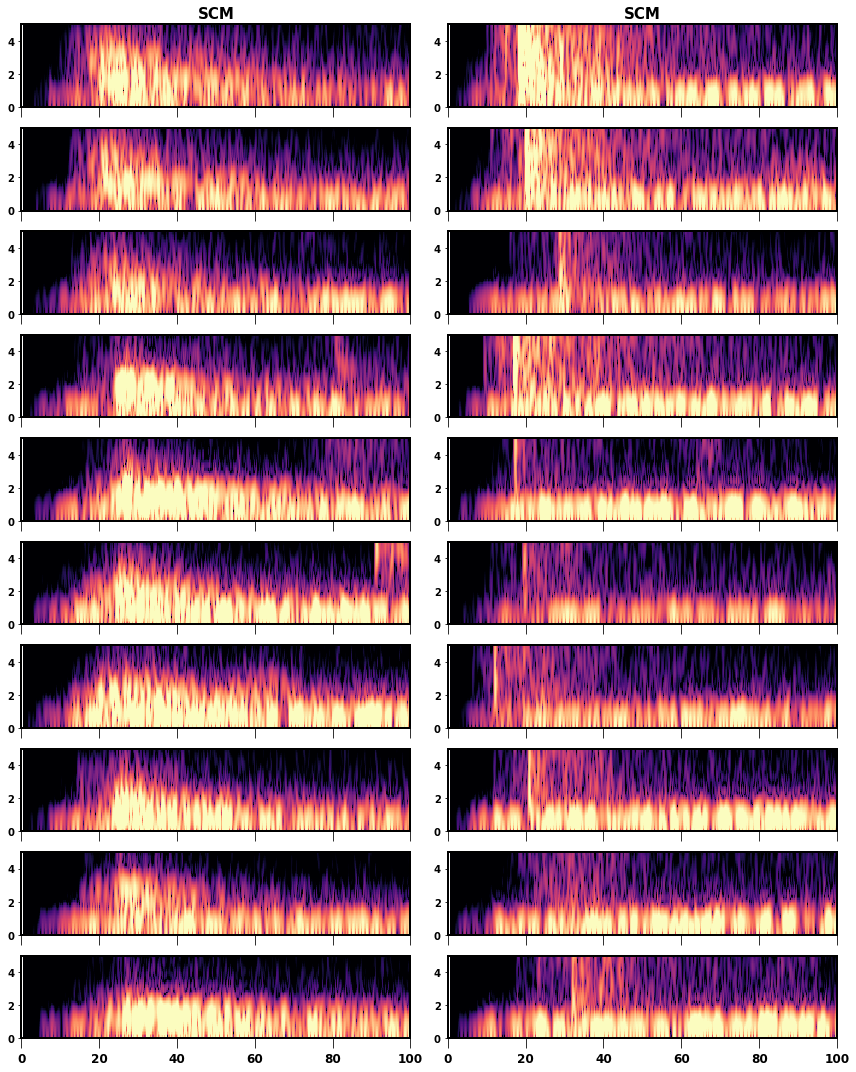

In [124]:
fig, ax= plt.subplots(nrows=10, ncols=2, figsize=(12,15), sharex='col', gridspec_kw=
                                                   { 'width_ratios':[1,1]})


station = 'SCM'
x = random.sample(range(100), 10)
r = np.array(glob('../Data/icequake_waveforms/*'+station+'*'))[x]


station1 = 'SCM'
x1 = random.sample(range(100), 10)
r1 = np.array(glob('../Data/earthquake_waveforms/*'+station1+'*'))[x1]


for i in range(10):
    st = obspy.read(r[i])
    st.taper(0.1)
    st.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st[0].times()
    yax = st[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][0])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][0].set_xlim(0,100)
    ax[i][0].set_ylim(0,5)
    ax[0][0].set_title(station, fontsize=15, fontweight = 'bold')
    
    
    
    st1 = obspy.read(r1[i])
    st1.taper(0.1)
    st1.filter('bandpass', freqmin=0.5, freqmax=5)
    time = st1[0].times()
    yax = st1[0].spectrogram(show=False,wlen=1,dbscale=True,cmap='magma',axes = ax[i][1])
    im = yax.images[0]
    im.set_clim(vmin=-10,vmax=30)    
    
    #ax[i][0].plot(time, st[0].data, lw=1.2)
    ax[i][1].set_xlim(0,100)
    ax[i][1].set_ylim(0,5)
    ax[0][1].set_title(station1, fontsize=15, fontweight = 'bold')    
fig.tight_layout()